In [1]:
# %%

# import math # roundは組み込み関数のため不要
# jax関連のライブラリを全てインポート
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap

# from LikelihoodEvaluator import LikelihoodEvaluator
# from ParameterEstimator import ParameterEstimator
from sympy import Array, symbols

from degenerate_sim import (
    DegenerateDiffusionProcess,
    LikelihoodEvaluator,
    m_estimate,
    newton_solve,
    m_estimate_jax,
    bayes_estimate
)
from degenerate_sim.evaluation.likelihood_evaluator_jax import SymbolicPreparationError

x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])

# インスタンス
FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

# Likelihood_FN = LikelihoodEvaluator(FNmodel)

In [50]:
true_theta1 = jnp.array([0.3])
true_theta2 = jnp.array([1.5, 0.8])
true_theta3 = jnp.array([0.1, 0.0])
true_theta = (true_theta1, true_theta2, true_theta3)
t_max = 50
burn_out = 50
h = 0.05
bounds_theta1 = [(0.1, 0.5)]
bounds_theta2 = [(0.5, 2.5), (0.5, 1.5)]
bounds_theta3 = [(0.01, 0.3), (-1, 1)]
n = t_max//h

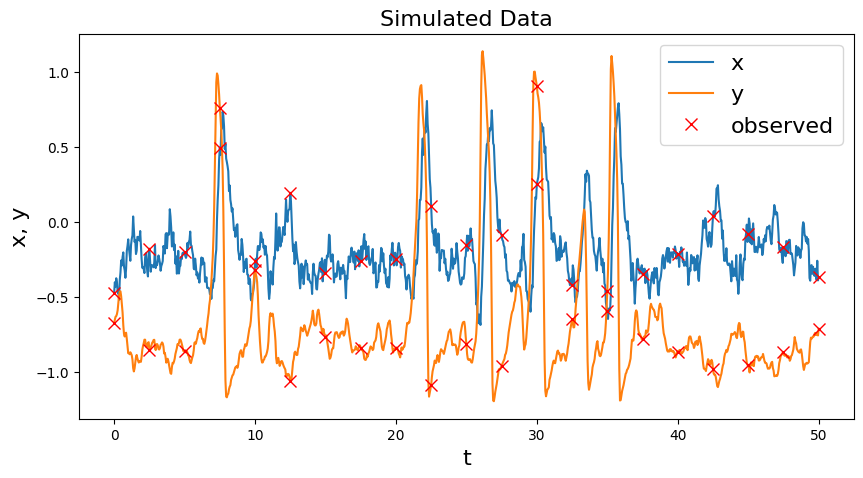

In [51]:
x_series, y_series = FNmodel.simulate(true_theta=true_theta, t_max=t_max, burn_out=burn_out, h=h)
t = jnp.linspace(0, t_max, len(x_series))
plt.figure(figsize=(10, 5))
plt.plot(t, x_series, label="x")
plt.plot(t, y_series, label="y")
plt.xlabel("t", fontsize=16)
plt.ylabel("x, y", fontsize=16)
plt.title("Simulated Data", fontsize=16)
# 5秒間隔で縦線をプロット
# 5秒間隔でグラフ上の点に大きなまるを表示
for i in range(0, len(t), 50):
    if i == 0:
        plt.plot(t[i], x_series[i], "x", color="red", markersize=8, label="observed")
        plt.plot(t[i], y_series[i], "x", color="red", markersize=8)
    else:
        plt.plot(t[i], x_series[i], "x", color="red", markersize=8)
        plt.plot(t[i], y_series[i], "x", color="red", markersize=8)
plt.legend(fontsize=16)
plt.show()

In [52]:
FN_likelihood = LikelihoodEvaluator(FNmodel)

In [55]:
k  = 7
v1 = FN_likelihood.make_quasi_likelihood_v1_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=k
)
v1_prime = FN_likelihood.make_quasi_likelihood_v1_prime_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=k
)
v2 = FN_likelihood.make_quasi_likelihood_v2_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=k
)
v3 = FN_likelihood.make_quasi_likelihood_v3_evaluator(
            x_series=x_series, y_series=y_series, h=h, k=k
        )

In [56]:
def a(n,h,k,i):
    if i == 1:
        return n**(-1/2)+ h**k
    if i == 2:
        return (n*h)**(-1/2) + h**k
    if i ==3:
        return (h/n)**(1/2) +h**(k+1)

In [57]:
def objective_func_1p(theta1_vec: jnp.ndarray) -> jnp.ndarray:
    return v1_prime(theta1_vec, true_theta1, true_theta2, true_theta3)/(a(n,h,k,1)**2)
def objective_func_1(theta1_vec: jnp.ndarray) -> jnp.ndarray:
    return v1(theta1_vec, true_theta1, true_theta2, true_theta3)/(a(n,h,k,1)**2)
def objective_func_2(theta2_vec: jnp.ndarray) -> jnp.ndarray:
    return v2(theta2_vec, true_theta1, theta2_vec, true_theta3)/(a(n,h,k,2)**2)
def objective_func_3(theta3_vec: jnp.ndarray) -> jnp.ndarray:
    return v3(theta3_vec, true_theta1, true_theta2, true_theta3)/(a(n,h,k,3)**2)

In [58]:
est_1_newton = newton_solve(
    objective_function=objective_func_1,
    search_bounds=bounds_theta1,
    initial_guess=jnp.array([0.2]),
    damping=0.5,
)
print(est_1_newton)
est_2_newton = newton_solve(
    objective_function=objective_func_2,
    search_bounds=bounds_theta2,
    initial_guess=jnp.array([0.5, 0.5]),
    damping=0.5,
)
print(est_2_newton)
est_3_newton = newton_solve(
        objective_function=objective_func_3,
        search_bounds=bounds_theta3,
        initial_guess=jnp.array([0.1, 0.0]),
        damping=0.5,
    )
print(est_3_newton)


[0.30325434]
[1.5017163  0.87338775]
[0.09936035 0.00028933]


In [59]:
est_1_bayes = bayes_estimate(
    objective_function=objective_func_1,
    search_bounds=bounds_theta1,
    initial_guess=jnp.array([0.2]),
)
print(est_1_bayes)
est_2_bayes = bayes_estimate(
    objective_function=objective_func_2,
    search_bounds=bounds_theta2,
    initial_guess=jnp.array([0.5, 0.5]),
)
print(est_2_bayes)
est_3_bayes = bayes_estimate(
        objective_function=objective_func_3,
        search_bounds=bounds_theta3,
        initial_guess=jnp.array([0.1, 0.0]),
    )
print(est_3_bayes)

[0.30372]
[1.5017011 0.8753415]
[0.09936133 0.00029903]


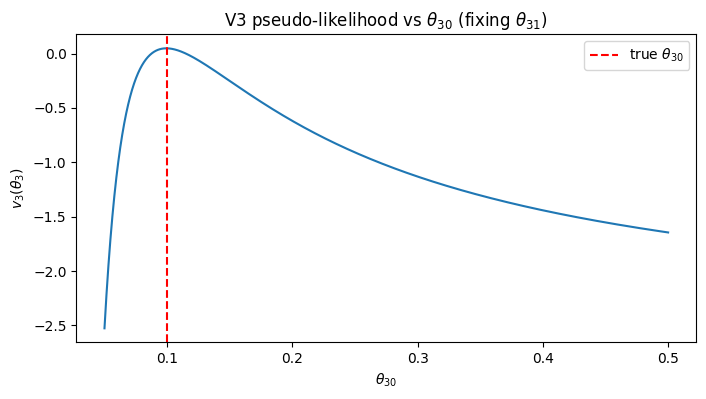

In [28]:
if v3 is None:
    print("V3 evaluator unavailable; skipping grid evaluation.")
else:
    theta30_grid = jnp.linspace(0.05, 0.5, 2000)  # 必要に応じて範囲を変更
    theta31_fixed = -9.359051e-06

    def v3_wrapper(theta30):
        theta3_vec = jnp.array([theta30, theta31_fixed])
        return v3(theta3_vec, true_theta1, true_theta2, true_theta3)

    v3_grid = vmap(v3_wrapper)(theta30_grid)

    plt.figure(figsize=(8, 4))
    plt.plot(theta30_grid, v3_grid)
    plt.axvline(true_theta3[0], color="red", linestyle="--", label=r"true $\theta_{30}$")
    plt.xlabel(r"$\theta_{30}$")
    plt.ylabel(r"$v_3(\theta_3)$")
    plt.title(r"V3 pseudo-likelihood vs $\theta_{30}$ (fixing $\theta_{31}$)")
    plt.legend()
    plt.show()


In [23]:
from tqdm.auto import tqdm

In [30]:
import numpy as np

num_trials = 30
rng_seeds = np.arange(num_trials)

newton_samples = {"theta1": [], "theta2": [], "theta3": []}
bayes_samples = {"theta1": [], "theta2": [], "theta3": []}
failed_seeds: list[int] = []

for seed in tqdm(rng_seeds):
    try:
        x_series_seed, y_series_seed = FNmodel.simulate(
            true_theta=true_theta,
            t_max=t_max,
            burn_out=burn_out,
            h=h,
            seed=int(seed),
        )

        v1_seed = FN_likelihood.make_quasi_likelihood_v1_evaluator(
            x_series=x_series_seed,
            y_series=y_series_seed,
            h=h,
            k=k,
        )
        v2_seed = FN_likelihood.make_quasi_likelihood_v2_evaluator(
            x_series=x_series_seed,
            y_series=y_series_seed,
            h=h,
            k=k,
        )
        v3_seed = FN_likelihood.make_quasi_likelihood_v3_evaluator(
            x_series=x_series_seed,
            y_series=y_series_seed,
            h=h,
            k=k,
        )
        def objective_func_1_seed(theta1_vec: jnp.ndarray) -> jnp.ndarray:
            return v1(theta1_vec, true_theta1, true_theta2, true_theta3)/(a(n,h,k,1)**2)
        def objective_func_2_seed(theta2_vec: jnp.ndarray) -> jnp.ndarray:
            return v2(theta2_vec, true_theta1, theta2_vec, true_theta3)/(a(n,h,k,2)**2)
        def objective_func_3_seed(theta3_vec: jnp.ndarray) -> jnp.ndarray:
            return v3(theta3_vec, true_theta1, true_theta2, true_theta3)/(a(n,h,k,3)**2)

        est_1_newton_seed = newton_solve(
            objective_function=objective_func_1_seed,
            search_bounds=bounds_theta1,
            initial_guess=jnp.array([0.2]),
            damping=0.5,
        )
        est_2_newton_seed = newton_solve(
            objective_function=objective_func_2_seed,
            search_bounds=bounds_theta2,
            initial_guess=jnp.array([0.5, 0.5]),
            damping=0.5,
        )
        est_3_newton_seed = newton_solve(
            objective_function=objective_func_3_seed,
            search_bounds=bounds_theta3,
            initial_guess=jnp.array([0.1, 0.0]),
            damping=0.5,
        )

        est_1_bayes_seed = bayes_estimate(
            objective_function=objective_func_1_seed,
            search_bounds=bounds_theta1,
            initial_guess=jnp.array([0.2]),
            num_samples=3000,
            num_warmup=1000,
            rng_seed=int(seed),
        )
        est_2_bayes_seed = bayes_estimate(
            objective_function=objective_func_2_seed,
            search_bounds=bounds_theta2,
            initial_guess=jnp.array([0.5, 0.5]),
            num_samples=3000,
            num_warmup=1000,
            rng_seed=int(seed),
        )
        est_3_bayes_seed = bayes_estimate(
            objective_function=objective_func_3_seed,
            search_bounds=bounds_theta3,
            initial_guess=jnp.array([0.1, 0.0]),
            num_samples=3000,
            num_warmup=1000,
            rng_seed=int(seed),
        )
    except SymbolicPreparationError as exc:
        print(f"[seed {int(seed)}] skipped due to symbolic preparation error: {exc}")
        failed_seeds.append(int(seed))
        continue
    except Exception as exc:
        print(f"[seed {int(seed)}] failed due to {exc}")
        failed_seeds.append(int(seed))
        continue

    newton_samples["theta1"].append(np.asarray(est_1_newton_seed))
    newton_samples["theta2"].append(np.asarray(est_2_newton_seed))
    newton_samples["theta3"].append(np.asarray(est_3_newton_seed))

    bayes_samples["theta1"].append(np.asarray(est_1_bayes_seed))
    bayes_samples["theta2"].append(np.asarray(est_2_bayes_seed))
    bayes_samples["theta3"].append(np.asarray(est_3_bayes_seed))

num_successful = len(newton_samples["theta1"])
if num_successful == 0:
    raise RuntimeError("All seeds failed; cannot compute summary statistics.")

stacked_newton = {theta: np.stack(samples, axis=0) for theta, samples in newton_samples.items()}
stacked_bayes = {theta: np.stack(samples, axis=0) for theta, samples in bayes_samples.items()}

summary = {}
for method_name, stacked in (("newton", stacked_newton), ("bayes", stacked_bayes)):
    method_summary = {}
    for theta_name, values in stacked.items():
        mean = values.mean(axis=0)
        variance = values.var(axis=0, ddof=1) if values.shape[0] > 1 else np.zeros_like(mean)
        method_summary[theta_name] = {"mean": mean, "variance": variance}
    summary[method_name] = method_summary

monte_carlo_samples = {
    "newton": stacked_newton,
    "bayes": stacked_bayes,
    "failed_seeds": failed_seeds,
}
monte_carlo_summary = summary

print(f"Completed {num_successful} successful trials out of {num_trials}.")
if failed_seeds:
    print(f"Skipped seeds: {failed_seeds}")

for method, method_summary in summary.items():
    print(f"\n{method.upper()} estimates:")
    for theta_name, stats in method_summary.items():
        mean = np.array2string(stats["mean"], precision=6, separator=", ")
        variance = np.array2string(stats["variance"], precision=6, separator=", ")
        print(f"  {theta_name}: mean={mean}, var={variance}")

  0%|          | 0/30 [00:00<?, ?it/s]

Completed 30 successful trials out of 30.

NEWTON estimates:
  theta1: mean=[0.309557], var=[9.188052e-16]
  theta2: mean=[1.596679, 0.87937 ], var=[1.470088e-14, 9.188052e-14]
  theta3: mean=[9.940053e-02, 4.471933e-05], var=[5.168280e-16, 3.422816e-22]

BAYES estimates:
  theta1: mean=[0.309648], var=[1.011382e-08]
  theta2: mean=[1.596685, 0.879278], var=[5.202578e-06, 3.197974e-06]
  theta3: mean=[9.940258e-02, 4.347584e-05], var=[5.249703e-11, 7.040563e-11]


In [16]:
summary

{'newton': {'theta1': {'mean': array([0.30521253], dtype=float32),
   'variance': array([1.3238088e-05], dtype=float32)},
  'theta2': {'mean': array([1.5149945, 0.8106417], dtype=float32),
   'variance': array([0.00286823, 0.00155959], dtype=float32)},
  'theta3': {'mean': array([ 9.973464e-02, -6.982600e-05], dtype=float32),
   'variance': array([6.6143777e-08, 1.6756711e-07], dtype=float32)}},
 'bayes': {'theta1': {'mean': array([0.33297452], dtype=float32),
   'variance': array([7.0886786e-06], dtype=float32)},
  'theta2': {'mean': array([1.6174091 , 0.93410456], dtype=float32),
   'variance': array([0.00083164, 0.00022535], dtype=float32)},
  'theta3': {'mean': array([ 0.18386433, -0.00028997], dtype=float32),
   'variance': array([1.6297856e-05, 2.2964148e-05], dtype=float32)}}}

In [17]:
stacked_bayes

{'theta1': array([[0.3357356 ],
        [0.33533633],
        [0.33237824],
        [0.3295738 ],
        [0.33192104],
        [0.33106816],
        [0.33291382],
        [0.33006713],
        [0.33293164],
        [0.32818753],
        [0.3351542 ],
        [0.3310572 ],
        [0.33294076],
        [0.33354637],
        [0.33170757],
        [0.340713  ],
        [0.33143964],
        [0.3323774 ],
        [0.32994327],
        [0.33183727],
        [0.3314109 ],
        [0.3301156 ],
        [0.33224937],
        [0.33347574],
        [0.33471227],
        [0.3368173 ],
        [0.3321107 ],
        [0.33551013],
        [0.33424085],
        [0.33776325]], dtype=float32),
 'theta2': array([[1.6236608 , 0.940159  ],
        [1.602841  , 0.9199576 ],
        [1.5645208 , 0.93201846],
        [1.5969938 , 0.9207835 ],
        [1.6436887 , 0.9240474 ],
        [1.5829855 , 0.9401293 ],
        [1.5994148 , 0.93644285],
        [1.5837951 , 0.9534311 ],
        [1.6389189 , 0.89745766